# README

We are playing with code that would take data from the brain and assess if each point is MoX or BiX. The objective function used to select parameters will then ensure that the MoX points are fit with the MoX function while the biX points are fit with the biX function. This file looks at the 6p model across a log scale of TI values.

There are two important functions here
1: the function that evaluates data as biX or moX --> returns a list of biX or moX
2: the objective function equation

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import sklearn
from sklearn.cluster import KMeans
import colorsys
from datetime import date
import pickle
import functools

# Initialize Parameters

In [2]:
####### Options #######
randStart = False                  #Initial guess for parameter values in random locations

In [16]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 45
T22 = 100

true_params = np.array([c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

assert(TE_DATA[-1] == 512)
d_TE = np.mean(np.diff(TE_DATA))
assert(d_TE == 8)


######### TI list option if we want to use general points
#Building the TI array - this is a log spacing
# desired_TI_low = 100
# desired_TI_high = 2500
# TI_numpoints = 15
# TI_DATA = np.logspace(np.log10(desired_TI_low), np.log10(desired_TI_high), TI_numpoints)

######### TI list option if we want to use null points and a control point
TI_DATA = np.array([np.log(2)*T11, np.log(2)*T12, 0])#(np.log(2)*T11 + np.log(2)*T12)/2])

#SNR Value to Evaluate
SNR_value = 100

#Parameters that dictate process related features
repetitions = 10     #number of noise realizations averaged

#Curve Fit Trials - how many times do we run curve_fit before we take a parameter fit solution
if randStart:
    randStart_trials = 10
else:
    randStart_trials = 1

#Builds a string of parameters to use in the titles
ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']
round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [4]:
#Defining the function of interest

def S_biX_6p(TE, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_3p_np1(TE, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T11))*np.exp(-TE/T2)

def S_moX_3p_np2(TE, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T12))*np.exp(-TE/T2)


def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

In [38]:
def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (0, 0, 1, 1)
        upper_bound = (1, 1, 300, 300)
    elif f_name == "S_moX_3p":
        lower_bound = (0, 1)
        upper_bound = (1, 300)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    true_params = [c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        f_name = func.__name__
        if f_name.find("moX") > -1:
            p0 = [0.5, 80]
        elif f_name.find("biX") > -1:
            p0 = [0.5, 0.5, 60, 80]
        else:
            p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, TI_value, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func(TI = TI_value), TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, TI_value, noisey_data)

    return popt, RSS

In [39]:
def BIC_opt1(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def BIC_opt2(RSS, TE_array, p_list):

    BIC = len(TE_array) * np.log(RSS/len(TE_array)) + len(p_list) * np.log(len(TE_array))

    return BIC

def evaluate_model(data, TI_val, func_moX, func_biX):

    popt_biX, RSS_biX = estP_oneCurve(func_biX, TI_val, data)
    popt_moX, RSS_moX = estP_oneCurve(func_moX, TI_val, data)

    BIC_biX = BIC_opt2(RSS_biX, TE_DATA, popt_biX)
    BIC_moX = BIC_opt2(RSS_moX, TE_DATA, popt_moX)

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX, func_moX
    else:
        return False, popt_biX, RSS_biX, func_biX


In [40]:
def objective_func(param_est, data_2d, TI_array, func_moX_np1 = S_moX_3p_np1, func_moX_np2 = S_moX_3p_np2,func_biX = S_biX_6p):
    assert(data_2d.shape[0] == len(TI_array))

    curve_RSS_array = []

    for curve_iter in range(data_2d.shape[0]):
        TI_val = TI_array[curve_iter]
        data_1d = data_2d[curve_iter,:]
        moX_opt, curve_popt, curve_RSS, choice_func = evaluate_model(data_1d, TI_val, func_moX, func_biX)

        if moX_opt:
            np_1st = [param_est[-4], param_est[-2]]
            RSS_1st_np = calculate_RSS(func_moX_np1, np_1st, TI_val, data_1d)

            np_2nd = [param_est[-3], param_est[-1]]
            RSS_2nd_np = calculate_RSS(func_moX_np2, np_2nd, TI_val, data_1d)

            curve_RSS_array.append(np.min([RSS_1st_np, RSS_2nd_np]))

        else:
            RSS = calculate_RSS(func_biX, param_est, TI_val, data_1d)

            curve_RSS_array.append(RSS)

    return np.sum(curve_RSS_array)

def RSS_obj_func(popt, func, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def callbackF(Xi, data):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}'.format(Nfeval, Xi[-4], Xi[-3], objective_func(Xi, data)))
    Nfeval += 1


In [41]:
def get_hist_index(param_label):
    if param_label[-1] == '2':
        row = 1
    else:
        row = 0

    if param_label[:-1] == "T1":
        col = 0
    elif param_label[:-1] == "c":
        col = 1
    else:
        col = 2

    return row, col

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, biMat, varMat

def parameter_histogram(paramStore, true_params, labels, add_title, percentage = False):
    fig, ax = plt.subplots(2, 2, figsize=(12,5.5), tight_layout=True)
    fig.suptitle(add_title)

    MSEMat, _, _ = calc_MSE(paramStore, true_params)

    for ii in range(paramStore.shape[1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        if percentage:
            ax[row, col].hist(x=paramStore[:,ii]/true_params[ii]*100, bins=20, color='b', label = labels[ii], alpha = 0.7)
            ax[row, col].set_xlabel('Param Percentage')
            ax[row, col].set_ylabel('Count')
            ax[row, col].axvline(x=100, linewidth=1, label= 'True ' + labels[ii], color='black')
            ax[row, col].axvline(x=np.mean(paramStore[:,ii]/true_params[ii]*100), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")
            
        else:
            ax[row, col].hist(x=paramStore[:,ii], bins=20, color='b', label = labels[ii], alpha = 0.7)
            ax[row, col].set_xlabel('Param Value')
            ax[row, col].set_ylabel('Count')
            ax[row, col].axvline(x=true_params[ii], linewidth=1, label= 'True ' + labels[ii], color='black')
            ax[row, col].axvline(x=np.mean(paramStore[:,ii]), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")
        
        ax[row, col].legend()
        ax[row, col].ticklabel_format(useOffset=False, style='scientific')
        ax[row, col].set_title('True ' + labels[ii] + '=' + "{:.2f}".format(true_params[ii]) + 
                    # '\nVar(' + paramTitle_6p[2*ii] + ') = ' +"{:.2e}".format(varMat[2*ii]) + 
                    # '\nBias(' + paramTitle_6p[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + labels[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()
    return

# Check Curve Fit vs. Minimize

In [43]:
TI_value = 0

biX_sig = S_biX_6p(TE_DATA, *true_params, TI_value)

noise_test = add_noise(biX_sig, SNR_value)

init_p = set_p0(S_biX_6p, random = True)

lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

# This uses curve fit to look for optimal params
popt, _ = curve_fit(functools.partial(S_biX_6p, TI = TI_value), TE_DATA, noise_test, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
popt = check_param_order(popt)
RSS = calculate_RSS(S_biX_6p, popt, TI_value, noise_test)

#reshaping the bounds for the minimization function

res = minimize(RSS_obj_func, init_p, args = (S_biX_6p, noise_test, TI_value), method = 'Powell', bounds = bnds, options = {'maxiter': 1000, 'disp': True})
min_popt = check_param_order(res.x)
min_RSS = res.fun

print("Comparison of Curve Fit and Minimize with RSS obj. func.")
print(f"Curve Fit :: popt = {popt} :: RSS = {RSS:.4f}")
print(f"Minimize :: popt = {min_popt} :: RSS = {min_RSS:.4f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 1281
Comparison of Curve Fit and Minimize with RSS obj. func.
Curve Fit :: popt = [8.63086730e+02 1.55158122e+03 3.63526857e-01 6.59312623e-01
 3.82587398e+01 9.86045396e+01] :: RSS = 0.0069
Minimize :: popt = [1.99999995e+03 1.99990710e+03 6.61069615e-05 1.10180543e-16
 1.00006134e+00 1.00006139e+00] :: RSS = 0.0000


# Data Processing

In [18]:
biX_data = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[-1])
moX_data1 = S_moX_3p_np2(TE_DATA, true_params[-4], true_params[-2], TI = TI_DATA[0])
moX_data2 = S_moX_3p_np1(TE_DATA, true_params[-3], true_params[-1], TI = TI_DATA[1])

all_data = np.stack((biX_data, moX_data1, moX_data2), axis = 0)

noised_data = add_noise(all_data, SNR_value)

assert(noised_data.shape[0] == 3)

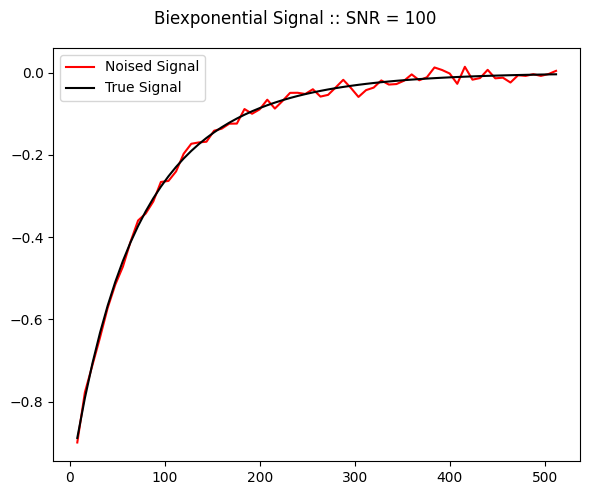

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
fig.suptitle(f'Biexponential Signal :: SNR = {SNR_value}')
ax.plot(TE_DATA, noised_data[0,:], color = 'r', label = 'Noised Signal')
ax.plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[-1]), color = 'k', label = 'True Signal')
ax.legend()

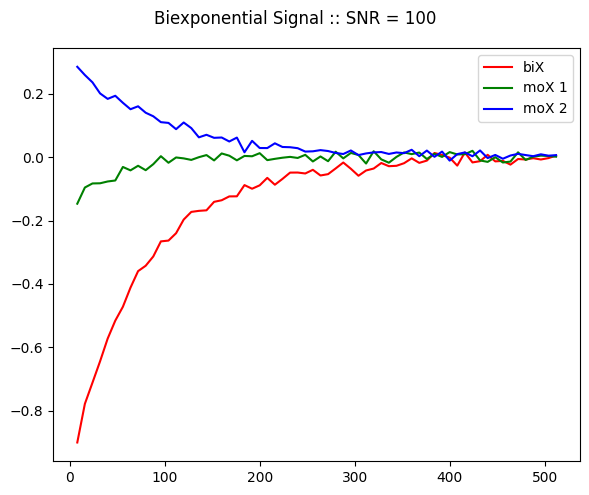

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
fig.suptitle(f'Biexponential Signal :: SNR = {SNR_value}')
ax.plot(TE_DATA, noised_data[0,:], color = 'r', label = 'biX')
ax.plot(TE_DATA, noised_data[1,:], color = 'g', label = 'moX 1')
ax.plot(TE_DATA, noised_data[2,:], color = 'b', label = 'moX 2')
ax.legend()

In [ ]:
data_truth = ["biX", "moX", "moX"]

print(f'True parameters of {ParamTitle_4p} are {true_params}\n')

for i in range(noised_data.shape[0]):
    moX_data, popt_params, RSS_opt, ___ = evaluate_model(noised_data[i,:], S_moX_2p, S_biX_4p)
    print(f'Data of type {data_truth[i]} was evaluate as {moX_data} for the moX model')
    print(f'Opt Params are determined as {popt_params} with RSS of {RSS_opt}\n')

True parameters of ['c1', 'c2', 'T21', 'T22'] are [  0.4   0.6  45.  100. ]

Data of type biX was evaluate as False for the moX model
Opt Params are determined as [  0.535325     0.4774599   47.55907207 111.38958728] with RSS of 0.003852375132872951

Data of type moX was evaluate as True for the moX model
Opt Params are determined as [ 0.37929181 46.15553024] with RSS of 0.005451645071042247

Data of type moX was evaluate as True for the moX model
Opt Params are determined as [  0.60116779 100.85543147] with RSS of 0.006669501877804225



In [ ]:
init_p = set_p0(S_biX_4p, random = True)

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_4p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

# cons = ({'type': 'ineq', 'fun': lambda x:  x[-3] - x[-2]}) #the goal is to be non negative - this ensures that x[-3] > x[-2]
# callback = lambda pDat:callbackF(pDat, noised_data)
Nfeval = 1
# print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format('Iter', ' c1', ' c2', 'f(X)'))
res = minimize(objective_func, init_p, args = (noised_data), method = 'Powell', bounds = bnds, options = {'maxiter': 1000, 'disp': True})

popt = check_param_order(res.x)
print(popt)


Optimization terminated successfully.
         Current function value: 0.016658
         Iterations: 13
         Function evaluations: 624
[  0.39493404   0.604226    43.95258766 100.2610981 ]


### only biX data

In [ ]:
biX_data = S_biX_4p(TE_DATA, *true_params)

all_data_biX = np.stack((biX_data, biX_data, biX_data), axis = 0)

noised_data_biX = add_noise(all_data_biX, SNR_value)

assert(noised_data_biX.shape[0] == 3)

In [ ]:
data_truth = ["biX", "biX", "biX"]

print(f'True parameters of {ParamTitle_4p} are {true_params}\n')

for i in range(noised_data.shape[0]):
    moX_data, popt_params, RSS_opt, ___ = evaluate_model(noised_data_biX[i,:], S_moX_2p, S_biX_4p)
    print(f'Data of type {data_truth[i]} was evaluate as {moX_data} for the moX model')
    print(f'Opt Params are determined as {popt_params} with RSS of {RSS_opt}\n')

True parameters of ['c1', 'c2', 'T21', 'T22'] are [  0.4   0.6  45.  100. ]

Data of type biX was evaluate as False for the moX model
Opt Params are determined as [  0.43354342   0.55397809  46.82219692 103.79726264] with RSS of 0.004538379654693994

Data of type biX was evaluate as False for the moX model
Opt Params are determined as [ 0.25846252  0.75889403 29.25652094 93.2316018 ] with RSS of 0.006540125864481699

Data of type biX was evaluate as False for the moX model
Opt Params are determined as [  0.78350366   0.19290934  65.71855871 147.0102279 ] with RSS of 0.006848871092028811



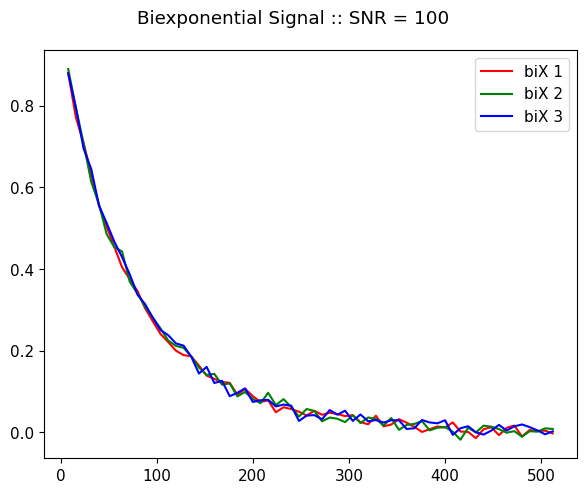

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
fig.suptitle(f'Biexponential Signal :: SNR = {SNR_value}')
ax.plot(TE_DATA, noised_data_biX[0,:], color = 'r', label = 'biX 1')
ax.plot(TE_DATA, noised_data_biX[1,:], color = 'g', label = 'biX 2')
ax.plot(TE_DATA, noised_data_biX[2,:], color = 'b', label = 'biX 3')
ax.legend()

In [ ]:
init_p = set_p0(S_biX_4p, random = True)

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_4p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

# cons = ({'type': 'ineq', 'fun': lambda x:  x[-3] - x[-2]}) #the goal is to be non negative - this ensures that x[-3] > x[-2]
# callback = lambda pDat:callbackF(pDat, noised_data)
Nfeval = 1
# print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format('Iter', ' c1', ' c2', 'f(X)'))
res = minimize(objective_func, init_p, args = (noised_data_biX), method = 'Powell', bounds = bnds, options = {'maxiter': 1000, 'disp': True})

popt = check_param_order(res.x)
print(popt)


Optimization terminated successfully.
         Current function value: 0.019738
         Iterations: 4
         Function evaluations: 161
[  0.69088525   0.28743245  60.91521615 128.01885422]


# Many Repetitions

In [ ]:
repetitions = 100

param_est_BIC = np.zeros((repetitions,len(true_params)))
n_evals_BIC = np.zeros(repetitions)
fval_BIC = np.zeros(repetitions)
nfev_BIC = np.zeros(repetitions)

param_est_biX = np.zeros((repetitions,len(true_params)))
n_evals_biX = np.zeros(repetitions)
fval_biX = np.zeros(repetitions)
nfev_biX = np.zeros(repetitions)

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_4p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

for rep in trange(repetitions):

    init_p = set_p0(S_biX_4p, random = True)

    noised_data = add_noise(all_data, SNR_value) #This is a data vector of [biX; moX; moX]
    res = minimize(objective_func, init_p, args = (noised_data), method = 'Powell', bounds = bnds, options = {'maxiter': 1000, 'disp': False})
    param_est_BIC[rep,:] = check_param_order(res.x)
    n_evals_BIC[rep] = res.nit
    fval_BIC[rep] = res.fun
    nfev_BIC[rep] = res.nfev

    noised_data_biX = add_noise(all_data_biX, SNR_value) #This is a data vector of [biX; moX; moX]
    res = minimize(objective_func, init_p, args = (noised_data_biX), method = 'Powell', bounds = bnds, options = {'maxiter': 1000, 'disp': False})
    param_est_biX[rep,:] = check_param_order(res.x)
    n_evals_biX[rep] = res.nit
    fval_biX[rep] = res.fun
    nfev_biX[rep] = res.nfev

100%|██████████| 100/100 [1:16:13<00:00, 45.73s/it]


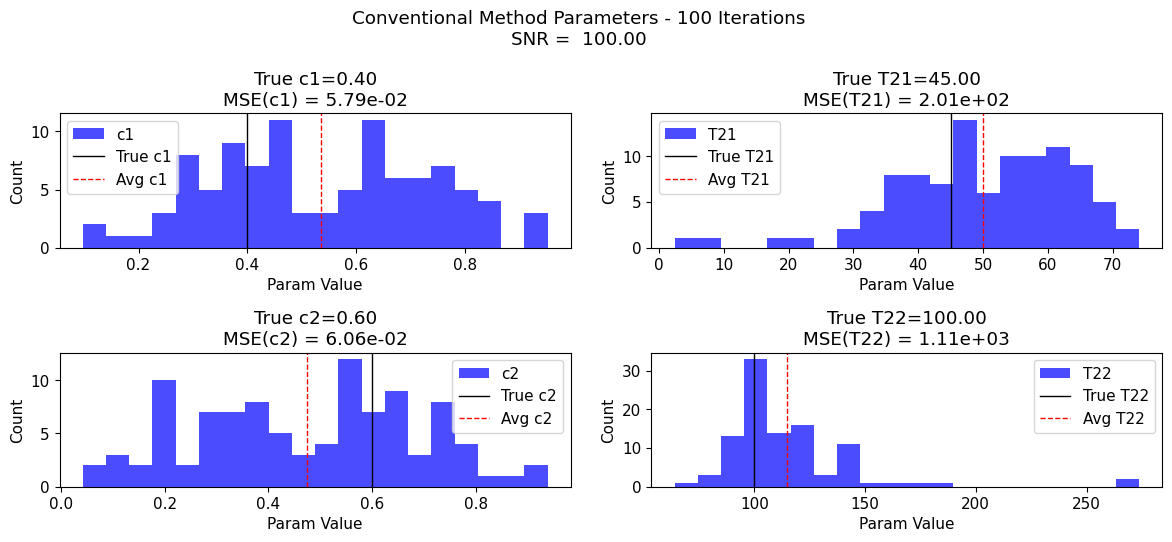

In [ ]:
title_hold = f"Conventional Method Parameters - {repetitions} Iterations\nSNR = {SNR_value : 0.2f}"
plt.rc('font', size = 11)
parameter_histogram(param_est_biX, true_params, ParamTitle_4p, title_hold, percentage = False)

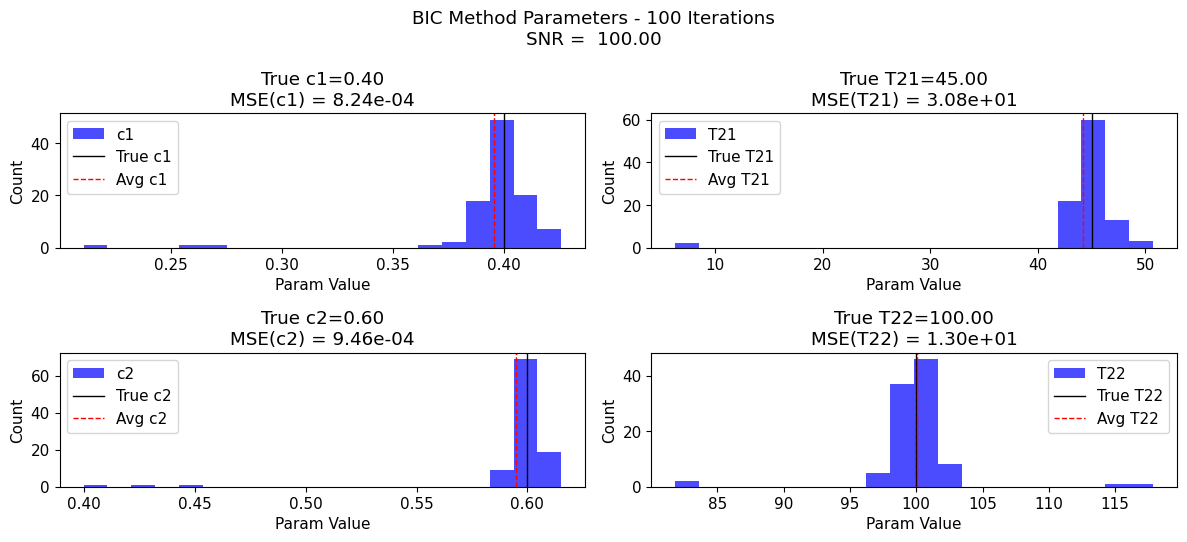

In [ ]:
title_hold = f"BIC Method Parameters - {repetitions} Iterations\nSNR = {SNR_value : 0.2f}"
plt.rc('font', size = 11)
parameter_histogram(param_est_BIC, true_params, ParamTitle_4p, title_hold, percentage = False)